In [1]:
from pyobo.sources.chebi import get_chebi_id_smiles_mapping
import pandas as pd
from indra_cogex.client import Neo4jClient
from rdkit.Chem import PandasTools

INFO: [2024-02-23 11:31:40] rdkit - Enabling RDKit 2023.03.3 jupyter extensions


In [2]:
chebi_smiles = get_chebi_id_smiles_mapping(version="230")
len(chebi_smiles)

184858

In [3]:
client = Neo4jClient()

INFO: [2024-02-23 11:31:41] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2024-02-23 11:31:41] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


In [4]:
# This query gets the genes/chemicals associated with pancreatic cancer
cypher = """\
    MATCH p=(chemical:BioEntity)-[]->(gene:BioEntity)-[]->(disease:BioEntity)
    WHERE disease.id in ['mesh:D010190', 'doid:1793']
       AND gene.type = 'human_gene_protein'
       AND chemical.type = 'small_molecule'
    RETURN chemical.id, chemical.name, count(DISTINCT gene.id) as n_genes
    ORDER BY n_genes DESC
"""

records = client.query_tx(cypher, )
records_df = pd.DataFrame(records, columns=['chemical_id', 'chemical_name', 'n_unique_genes'])

In [5]:
# Add smiles based on ChEBI lookup
records_df["smiles"] = records_df["chemical_id"].map(lambda s: chebi_smiles.get(s.strip('chebi:')))

records_df.to_csv("chemical_gene_disease.tsv", sep='\t', index=False)

[11:31:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 2 O, 3, is greater than permitted
[11:31:50] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:31:50] WARNING: not removing hydrogen atom without neighbors
[11:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 34 N, 4, is greater than permitted
[11:31:50] Explicit valence for atom # 7 O, 3, is greater than permitted
[11:31:50] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:31:50] WARNING: not removing hydrogen atom without neighbors
[11:31:50] Conflicting single bond directions around double bond at index 20.
[11:31:50]   BondStereo set to STEREONONE and single bond dir

,chemical_id,chemical_name,n_unique_genes,smiles,ROMol
0,chebi:33216,bisphenol A,754,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,
1,chebi:39867,valproic acid,704,CCCC(CCC)C(O)=O,
2,chebi:28119,"2,3,7,8-tetrachlorodibenzodioxine",628,Clc1cc2Oc3cc(Cl)c(Cl)cc3Oc2cc1Cl,
3,chebi:29865,benzo[a]pyrene,621,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,
4,chebi:27899,cisplatin,585,[H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H],None
...,...,...,...,...,...
14674,chebi:60889,"5,5'-dimethyl-BAPTA",1,Cc1ccc(N(CC(O)=O)CC(O)=O)c(OCCOc2cc(C)ccc2N(CC...,
14677,chebi:32087,Ramatroban,1,C(CC(O)=O)N1C2=C(C=3C1=CC=CC3)C[C@@H](CC2)NS(=...,
14679,chebi:3721,cisatracurium besylate,1,[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c1ccccc1.CO...,
14681,chebi:70645,Dehydrocorydalmine,1,COc1cc2CC[n+]3cc4c(OC)c(O)ccc4cc3-c2cc1OC,

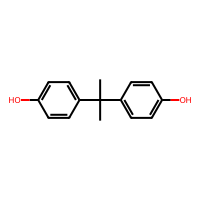
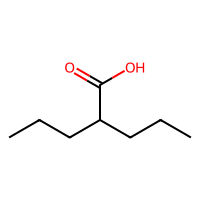
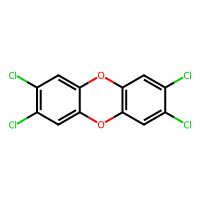
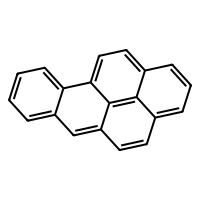
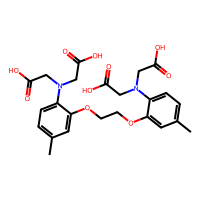
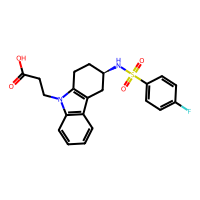
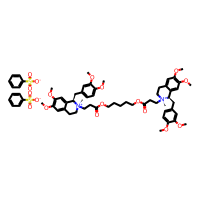
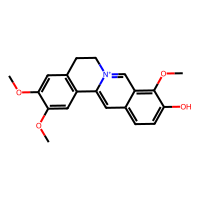
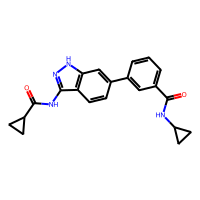

In [6]:
# Remove chemicals without structures
records_df = records_df[records_df["smiles"].notna()]

# Add nice chemical structures
PandasTools.AddMoleculeColumnToFrame(records_df, "smiles")

records_df